In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet


import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch
import transformers


c:\users\furqan ali\desktop\python\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_json("./news_dataset/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [3]:
df.drop('article_link', axis=1, inplace=True)

In [4]:
# 2. Basic Data Cleaning

# import nltk
# nltk.download('stopwords')

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [5]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['headline']=df['headline'].apply(denoise_text)

c:\users\furqan ali\desktop\python\env\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [6]:
# 3. Creating the vocabulary


def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.headline)
corpus[:5]

['thirtysomething', 'scientists', 'unveil', 'doomsday', 'clock']

In [7]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'new': 1637,
 'man': 1351,
 'trump': 1284,
 'one': 527,
 'area': 494,
 'woman': 483,
 'says': 482,
 'donald': 472,
 'day': 435,
 'like': 428}

In [8]:
# 4. Model Building

X = df['headline']
y = df['is_sarcastic']

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 0 , stratify = y)


## pip install transformers
## If transformers library is not installed

In [9]:
from tokenizers import BertWordPieceTokenizer
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True)
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer


Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

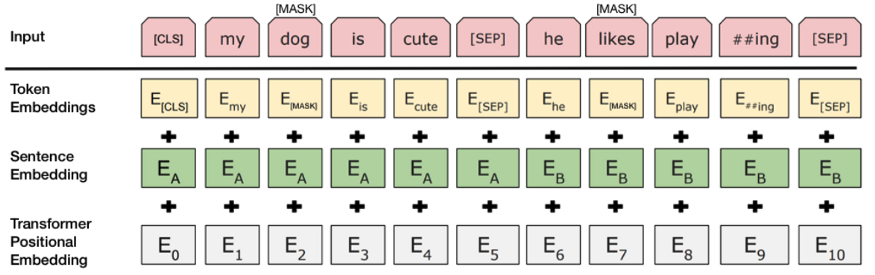

In [10]:
# Before any sentence is passed into the BERT model, it has to go through some tokenization steps.

# Firstly, tokenize all words in the sentence corpus
# Next, all the tokens are embedded using the learned embeddings from a WordPiece Tokenizer. For each word we get 786 dim. vector representation.
# Segment Embedding - Helps in distinguishing the words belonging to different sentences.
# Positional Embedding - This is used to provide the positional understanding for each word.

In [11]:
from transformers import BertTokenizer, BertTokenizerFast

def fast_encode(texts, tokenizer, chunk_size=256, maxlen=400):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [12]:
# tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

# batch = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors="tf")

x_train = fast_encode(X_train.values, fast_tokenizer, maxlen=100)
x_test = fast_encode(X_test.values, fast_tokenizer, maxlen=100)

In [13]:
# We shall be using the pre-trained BERT model which has been extensively trained on huge text corpuses of Wikipedia. 
# Now after getting the pre-trained model, we can fine-tune the model for our own specific task.

# The key thing to notice is here is that for our final prediction we would only be using the output generated by the first 
# token ([CLS]), after which we use a sigmoid activation for final prediction.

In [14]:
def build_model(transformer, max_len=400):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


Downloading the pre-trained BERT model. We can use either the CASED or the UNCASED version for model building.

To explain the BERT training in simple words: The BERT pre-training consists of two steps which happen parallely, these include:

1. Masked Language Model
In this the model is provided with sentences and some of the words are masked with a [MASK] tag (15% of all words), the model is then asked to predict those masked words. The BERT loss function takes into consideration only the prediction of the masked values and ignores the prediction of the non-masked words. As a consequence, the model converges slower than directional models, a characteristic which is offset by its increased context awareness.

2. Next Sentence Prediction
In the BERT training process, the model receives pairs of sentences as input and learns to predict if the second sentence in the pair is the subsequent sentence in the original document. This helps the model to understand the relationships between

In [15]:
bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

model = build_model(bert_model, max_len=100)
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 100)]            0         
                                                                 
 tf_distil_bert_model (TFDis  TFBaseModelOutput(last_h  66362880 
 tilBertModel)               idden_state=(None, 100,             
                             768),                               
                              hidden_states=None, att            
                             entions=None)                       
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                                 
 dense (Dense)               (None, 1)                 769       
                                                             

c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [16]:
history = model.fit(x_train,y_train,batch_size = 32 ,validation_data=(x_test,y_test),epochs = 3)

Epoch 1/3


ResourceExhaustedError: Graph execution error:

Detected at node 'model/tf_distil_bert_model/distilbert/transformer/layer_._2/ffn/lin2/Tensordot/MatMul' defined at (most recent call last):
    File "C:\Users\Furqan Ali\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\Furqan Ali\AppData\Local\Programs\Python\Python38\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Furqan Ali\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\Furqan Ali\AppData\Local\Programs\Python\Python38\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\Furqan Ali\AppData\Local\Programs\Python\Python38\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\ipykernel\kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\ipykernel\kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\ipykernel\kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Furqan Ali\AppData\Local\Temp\ipykernel_20184\1581764096.py", line 1, in <cell line: 1>
      history = model.fit(x_train,y_train,batch_size = 32 ,validation_data=(x_test,y_test),epochs = 3)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\transformers\modeling_tf_utils.py", line 544, in run_call_with_unpacked_inputs
      f" {main_input_name}."
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 546, in call
      outputs = self.distilbert(
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\transformers\modeling_tf_utils.py", line 544, in run_call_with_unpacked_inputs
      f" {main_input_name}."
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 401, in call
      tfmr_output = self.transformer(
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 313, in call
      for i, layer_module in enumerate(self.layer):
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 317, in call
      layer_outputs = layer_module(hidden_state, attn_mask, head_mask[i], output_attentions, training=training)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 274, in call
      ffn_output = self.ffn(sa_output, training=training)  # (bs, seq_length, dim)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\transformers\models\distilbert\modeling_tf_distilbert.py", line 229, in call
      x = self.lin2(x)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\users\furqan ali\desktop\python\env\lib\site-packages\keras\layers\core\dense.py", line 224, in call
      outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
Node: 'model/tf_distil_bert_model/distilbert/transformer/layer_._2/ffn/lin2/Tensordot/MatMul'
OOM when allocating tensor with shape[3200,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/tf_distil_bert_model/distilbert/transformer/layer_._2/ffn/lin2/Tensordot/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_14364]

In [ ]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

In [ ]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
pred = model.predict(x_test)
pred[:5]

In [ ]:
pred = np.round(pred).astype(int)
pred[:5]

In [ ]:
print(classification_report(y_test, pred))

In [ ]:
cm = confusion_matrix(y_test,pred)
print(cm)

plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.xlabel("Predicted")
plt.ylabel("Actual")